In [19]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

### YOLO pretraining on RSNA Dataset

In [20]:
loss_path = "./losses/"
train_loss = np.load(loss_path + "yolov5_train_loss_28.np.npy")
val_loss = np.load(loss_path + "yolov5_val_loss_28.np.npy" )
assert len(val_loss) == len(train_loss)

In [21]:
#train_single_losses = np.load(loss_path + "yolov5_train_loss_single_28.np.npy")
#val_single_losses = np.load(loss_path + "yolov5_val_loss_single_28.np.npy")

In [22]:
file = open(loss_path + "yolov5_general_test_results_28.pickle",'rb')
metrics_list = pickle.load(file)
file.close()

type(metrics_list)

list

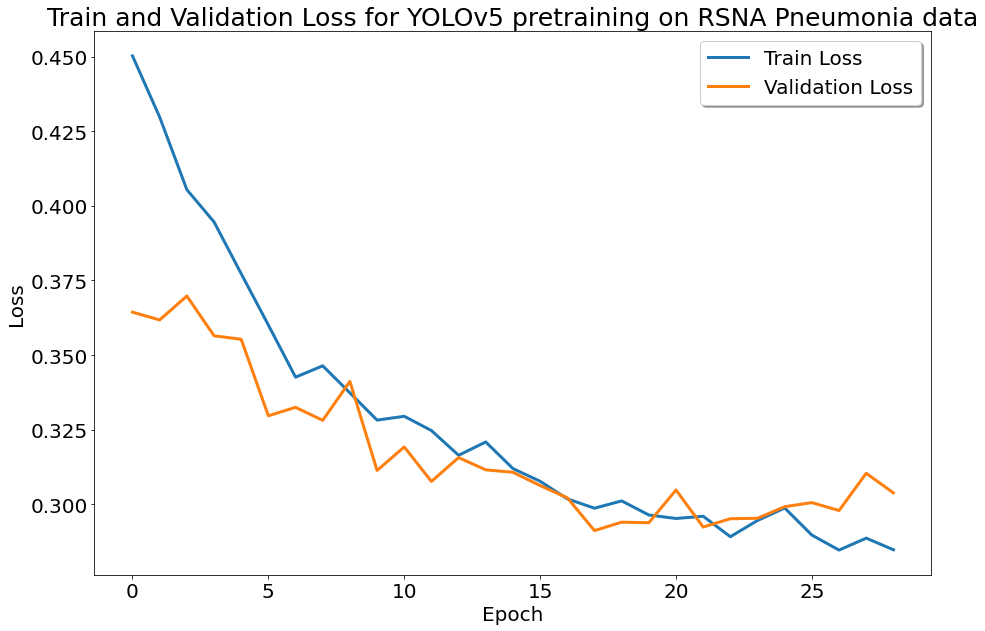

In [26]:
x = [i for i in range(len(val_loss))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,train_loss , label="Train Loss", linewidth=3)
plt.plot(x,val_loss, label="Validation Loss", linewidth=3)
plt.title("Train and Validation Loss for YOLOv5 pretraining on RSNA Pneumonia data", fontsize=25)
plt.ylabel("Loss",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/loss_yolo_30.png",dpi=200)

In [49]:
precision, recall, ap, f1, ap_class, ap50, mp, mr, map50 = [], [], [], [], [], [], [], [], []

In [50]:
for metrics in metrics_list:
    precision.append(metrics["precision"][0])
    recall.append(metrics["recall"][0])
    ap.append(metrics["ap"][0])
    f1.append(metrics["f1"][0])
    ap_class.append(metrics["ap_class"][0])
    ap50.append(metrics["ap50"][0])
    mp.append(metrics["mp"])
    mr.append(metrics["mr"])
    map50.append(metrics["map50"])

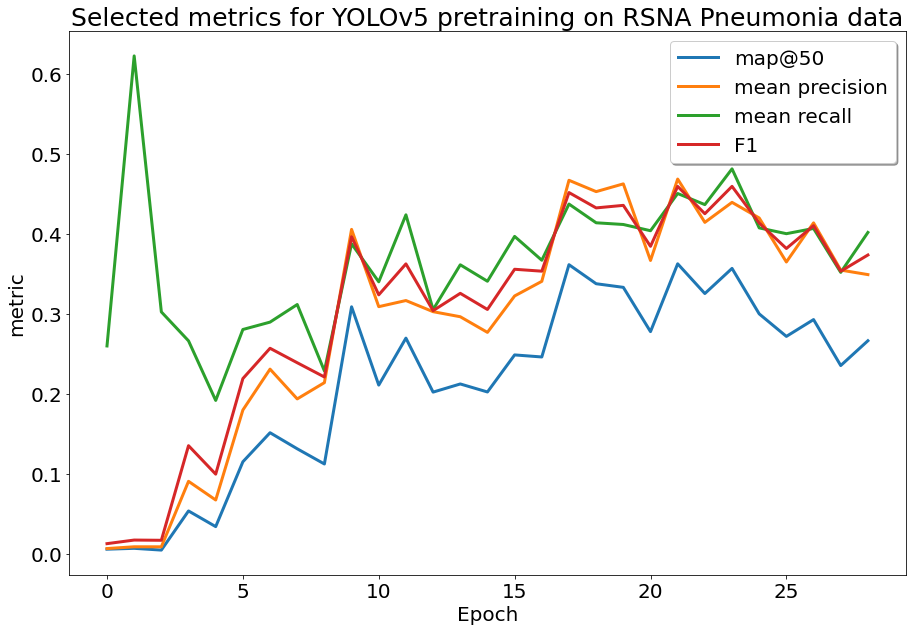

In [53]:
x = [i for i in range(len(map50))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,map50 , label="map@50", linewidth=3)
plt.plot(x,mp, label="mean precision", linewidth=3)
plt.plot(x,mr, label="mean recall", linewidth=3)
plt.plot(x,f1, label="F1", linewidth=3)
plt.title("Selected metrics for YOLOv5 pretraining on RSNA Pneumonia data", fontsize=25)
plt.ylabel("metric",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/metrics_yolo_30.png",dpi=200)

## TODO: YOLO training on SIIM